# Temporal Fusion Transformer (TFT) for Stock Return Prediction

## Objective
Implement state-of-the-art Temporal Fusion Transformer for multi-horizon stock forecasting.

## TFT Advantages
1. **Attention Mechanisms**: Identify important time steps and features
2. **Multi-Horizon Native**: Built for forecasting multiple time steps
3. **Quantile Predictions**: Uncertainty estimation (prediction intervals)
4. **Interpretability**: Variable importance and attention weights
5. **Static & Dynamic Features**: Handle both time-varying and constant features

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import warnings
from typing import Tuple, List
import time

# PyTorch
import torch
from torch.utils.data import DataLoader

# PyTorch Lightning
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

# PyTorch Forecasting
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer, EncoderNormalizer
from pytorch_forecasting.metrics import QuantileLoss, MAE, RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# ML metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score

# MLflow
import mlflow

warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [2]:
# Configuration
DATA_DIR = Path('data/processed/stock_data')
MLFLOW_EXPERIMENT_NAME = 'stock-tft-forecasting'
WINDOW_SIZE = 60
HORIZON = 7
BATCH_SIZE = 64
MAX_EPOCHS = 20

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

FEATURE_NAMES = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'OI',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50',
    'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Hist',
    'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower',
    'Volume_SMA_20', 'Volume_Ratio',
    'Daily_Return', 'Price_Range', 'Price_Change',
    'Return_3d', 'Return_5d', 'Return_10d', 'Log_Return',
    'Volatility_5d', 'Volatility_20d', 'Momentum_10d', 'Momentum_20d'
]

Using device: cpu


## 1. Data Loading and Preprocessing

In [3]:
def add_return_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add return-based features to dataframe."""
    df = df.copy()
    df['Return_3d'] = df['Close'].pct_change(3) * 100
    df['Return_5d'] = df['Close'].pct_change(5) * 100
    df['Return_10d'] = df['Close'].pct_change(10) * 100
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1)) * 100
    df['Volatility_5d'] = df['Daily_Return'].rolling(5).std()
    df['Volatility_20d'] = df['Daily_Return'].rolling(20).std()
    df['Momentum_10d'] = df['Close'] - df['Close'].shift(10)
    df['Momentum_20d'] = df['Close'] - df['Close'].shift(20)
    return df.dropna()


def load_all_stocks_as_dataframe():
    """Load all stocks into a single dataframe (required for TFT)."""
    csv_files = sorted(glob.glob(str(DATA_DIR / "*_historical.csv")))
    print(f"Found {len(csv_files)} stock files")
    
    all_data = []
    
    for file_path in csv_files:
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)
        df = add_return_features(df)
        
        if len(df) > WINDOW_SIZE + HORIZON:
            symbol = Path(file_path).stem.replace('_historical', '')
            df['Symbol'] = symbol
            all_data.append(df)
    
    # Concatenate all stocks
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Sort by symbol and date
    combined_df = combined_df.sort_values(['Symbol', 'Date']).reset_index(drop=True)
    
    # Create time index (required by TFT)
    combined_df['time_idx'] = combined_df.groupby('Symbol').cumcount()
    
    # Calculate target: 7-day forward return
    combined_df['target_return'] = combined_df.groupby('Symbol')['Close'].transform(
        lambda x: ((x.shift(-HORIZON) - x) / x * 100)
    )
    
    # Direction (for evaluation)
    combined_df['target_direction'] = (combined_df['target_return'] > 0).astype(int)
    
    # Remove rows without targets
    combined_df = combined_df.dropna(subset=['target_return'])
    
    print(f"\nTotal rows: {len(combined_df):,}")
    print(f"Unique stocks: {combined_df['Symbol'].nunique()}")
    print(f"Date range: {combined_df['Date'].min()} to {combined_df['Date'].max()}")
    
    return combined_df

In [4]:
# Load data
data = load_all_stocks_as_dataframe()

# Display sample
print("\nSample data:")
display(data[['Symbol', 'Date', 'time_idx', 'Close', 'target_return', 'target_direction'] + FEATURE_NAMES[:5]].head(10))

Found 98 stock files

Total rows: 43,120
Unique stocks: 98
Date range: 2024-01-15 00:00:00+05:30 to 2025-10-21 00:00:00+05:30

Sample data:


,Symbol,Date,time_idx,Close,target_return,target_direction,Open,High,Low,Close,Volume
0,ABB,2024-01-15 00:00:00+05:30,0,4752.90,-0.455511,0,4809.00,4809.00,4725.00,4752.90,104057
1,ABB,2024-01-16 00:00:00+05:30,1,4809.30,-1.455513,0,4770.00,4842.30,4750.05,4809.30,192280
2,ABB,2024-01-17 00:00:00+05:30,2,4773.05,0.387593,1,4798.00,4863.70,4731.40,4773.05,163852
3,ABB,2024-01-18 00:00:00+05:30,3,4710.35,0.411859,1,4765.00,4797.40,4665.00,4710.35,151382
4,ABB,2024-01-19 00:00:00+05:30,4,4820.45,-3.087886,0,4738.45,4844.10,4738.45,4820.45,132723
5,ABB,2024-01-20 00:00:00+05:30,5,4750.95,-4.312822,0,4845.00,4845.00,4730.00,4750.95,49467
6,ABB,2024-01-23 00:00:00+05:30,6,4770.55,-6.081060,0,4750.95,4897.00,4735.90,4770.55,348426
7,ABB,2024-01-24 00:00:00+05:30,7,4731.25,-7.673448,0,4764.95,4814.90,4613.80,4731.25,293735
8,ABB,2024-01-25 00:00:00+05:30,8,4739.30,-7.095985,0,4768.00,4794.95,4665.00,4739.30,114581
9,ABB,2024-01-29 00:00:00+05:30,9,4791.55,-4.517327,0,4751.00,4807.15,4715.40,4791.55,87854


## 2. Train/Validation/Test Split (Hybrid: Stock-Based + Time-Based)

In [5]:
# Stock-based split (matching notebooks 03, 04a, 04b): 80% stocks train, 20% test
# Within training stocks, use time-based validation for TFT early stopping

# Step 1: Split stocks into train (80%) and test (20%) - matching other notebooks
stock_symbols = data['Symbol'].unique()
n_test_stocks = int(len(stock_symbols) * 0.2)
n_train_stocks = len(stock_symbols) - n_test_stocks

np.random.seed(42)
shuffled_symbols = np.random.permutation(stock_symbols)

train_symbols = shuffled_symbols[:n_train_stocks]  # 80% of stocks
test_symbols = shuffled_symbols[n_train_stocks:]   # 20% of stocks

# Step 2: Within training stocks, split by time (85% train, 15% validation)
def split_train_by_time(group):
    """Split each training stock by time: 85% train, 15% validation"""
    n = len(group)
    train_end = int(n * 0.85)
    
    group['split'] = 'val'
    group.loc[group.index[:train_end], 'split'] = 'train'
    
    return group

# Initialize all as test
data['split'] = 'test'

# Apply time-based split only to training stocks
train_stocks_data = data[data['Symbol'].isin(train_symbols)].copy()
train_stocks_data = train_stocks_data.groupby('Symbol', group_keys=False).apply(split_train_by_time)

# Update the main dataframe with train/val splits
data.loc[train_stocks_data.index, 'split'] = train_stocks_data['split']

# Split datasets
train_data = data[data['split'] == 'train'].copy()
val_data = data[data['split'] == 'val'].copy()
test_data = data[data['split'] == 'test'].copy()

print("\n" + "="*80)
print("DATA SPLIT (STOCK-BASED + TIME-BASED VALIDATION)")
print("="*80)
print(f"\nStock Split:")
print(f"  Training stocks: {len(train_symbols)} ({len(train_symbols)/len(stock_symbols)*100:.1f}%)")
print(f"  Test stocks:     {len(test_symbols)} ({len(test_symbols)/len(stock_symbols)*100:.1f}%)")

print(f"\nData Split:")
print(f"  Train set: {len(train_data):,} rows ({len(train_data)/len(data)*100:.1f}%) - {train_data['Symbol'].nunique()} stocks")
print(f"  Val set:   {len(val_data):,} rows ({len(val_data)/len(data)*100:.1f}%) - {val_data['Symbol'].nunique()} stocks")
print(f"  Test set:  {len(test_data):,} rows ({len(test_data)/len(data)*100:.1f}%) - {test_data['Symbol'].nunique()} stocks")

print(f"\nTrain stocks (first 5): {list(train_symbols[:5])}")
print(f"Test stocks (first 5):  {list(test_symbols[:5])}")

print(f"\nTrain date range: {train_data['Date'].min()} to {train_data['Date'].max()}")
print(f"Val date range:   {val_data['Date'].min()} to {val_data['Date'].max()}")
print(f"Test date range:  {test_data['Date'].min()} to {test_data['Date'].max()}")

print("\nNote:")
print("  - Training stocks (79) are split by TIME: first 85% for train, last 15% for validation")
print("  - Test stocks (19) are COMPLETELY UNSEEN during training")
print("  - This matches the 80/20 stock split used in notebooks 03, 04a, 04b")


DATA SPLIT (STOCK-BASED + TIME-BASED VALIDATION)

Stock Split:
  Training stocks: 79 (80.6%)
  Test stocks:     19 (19.4%)

Data Split:
  Train set: 29,546 rows (68.5%) - 79 stocks
  Val set:   5,214 rows (12.1%) - 79 stocks
  Test set:  8,360 rows (19.4%) - 19 stocks

Train stocks (first 5): ['M&M', 'HDFCBANK', 'UNIONBANK', 'BHARTIARTL', 'SIEMENS']
Test stocks (first 5):  ['TORNTPHARM', 'HAL', 'DLF', 'ABBOTINDIA', 'IOC']

Train date range: 2024-01-15 00:00:00+05:30 to 2025-07-16 00:00:00+05:30
Val date range:   2025-07-17 00:00:00+05:30 to 2025-10-21 00:00:00+05:30
Test date range:  2024-01-15 00:00:00+05:30 to 2025-10-21 00:00:00+05:30

Note:
  - Training stocks (79) are split by TIME: first 85% for train, last 15% for validation
  - Test stocks (19) are COMPLETELY UNSEEN during training
  - This matches the 80/20 stock split used in notebooks 03, 04a, 04b


## 3. Create TimeSeriesDataSet for TFT

In [6]:
# Define max prediction length (horizon)
max_prediction_length = 1  # Predict 1 step ahead (7-day return)
max_encoder_length = WINDOW_SIZE  # Use 60 days of history

# CRITICAL FIX: The issue is the softplus transformation creates NaN for negative values
# We need to use a different normalizer or handle negative returns differently

print("Fixing time_idx continuity issue...")
print(f"Train data shape before cleaning: {train_data.shape}")

# First, check for NaN/inf in features and target
all_columns = FEATURE_NAMES + ["target_return", "target_direction"]
print("\nChecking for NaN/infinite values:")
for col in all_columns:
    if col in train_data.columns:
        nan_count = train_data[col].isna().sum()
        inf_count = np.isinf(train_data[col]).sum()
        if nan_count > 0 or inf_count > 0:
            print(f"  {col}: {nan_count} NaN, {inf_count} inf values")

# Remove rows with NaN or infinite values
train_data_clean = train_data.copy()
for col in all_columns:
    if col in train_data_clean.columns:
        train_data_clean = train_data_clean[~train_data_clean[col].isna()]
        train_data_clean = train_data_clean[~np.isinf(train_data_clean[col])]

print(f"\nAfter removing NaN/inf: {train_data_clean.shape}")

# Check target_return distribution
print(f"\ntarget_return statistics:")
print(f"  Min: {train_data_clean['target_return'].min():.4f}")
print(f"  Max: {train_data_clean['target_return'].max():.4f}")
print(f"  Mean: {train_data_clean['target_return'].mean():.4f}")
print(f"  Negative values: {(train_data_clean['target_return'] < 0).sum()} ({(train_data_clean['target_return'] < 0).sum() / len(train_data_clean) * 100:.1f}%)")

# CRITICAL: Reset time_idx to be continuous for each Symbol
print("\nResetting time_idx to be continuous for each stock...")
train_data_clean = train_data_clean.sort_values(['Symbol', 'Date']).reset_index(drop=True)
train_data_clean['time_idx'] = train_data_clean.groupby('Symbol').cumcount()

# Verify each stock has enough data
min_required_length = max_encoder_length + max_prediction_length
stocks_to_remove = []
for symbol in train_data_clean['Symbol'].unique():
    symbol_data = train_data_clean[train_data_clean['Symbol'] == symbol]
    if len(symbol_data) < min_required_length:
        stocks_to_remove.append(symbol)
        print(f"  Removing {symbol}: only {len(symbol_data)} rows (need {min_required_length})")

if stocks_to_remove:
    train_data_clean = train_data_clean[~train_data_clean['Symbol'].isin(stocks_to_remove)]
    print(f"\nRemoved {len(stocks_to_remove)} stocks with insufficient data")

# Reset time_idx again after removing stocks
train_data_clean = train_data_clean.sort_values(['Symbol', 'Date']).reset_index(drop=True)
train_data_clean['time_idx'] = train_data_clean.groupby('Symbol').cumcount()

# Apply same cleaning to val and test data (WITHOUT filtering by training stocks)
print("\nCleaning validation and test data...")
val_data_clean = val_data.copy()
test_data_clean = test_data.copy()

# IMPORTANT: Validation data comes from same stocks as training (time-based split)
# So we filter validation to only keep stocks present in training
val_data_clean = val_data_clean[val_data_clean['Symbol'].isin(train_data_clean['Symbol'].unique())]

# IMPORTANT: Test data comes from DIFFERENT stocks (stock-based split)
# So we do NOT filter test data - keep all test stocks as-is

# Remove NaN/inf from val
for col in all_columns:
    if col in val_data_clean.columns:
        val_data_clean = val_data_clean[~val_data_clean[col].isna()]
        val_data_clean = val_data_clean[~np.isinf(val_data_clean[col])]

# Remove NaN/inf from test
for col in all_columns:
    if col in test_data_clean.columns:
        test_data_clean = test_data_clean[~test_data_clean[col].isna()]
        test_data_clean = test_data_clean[~np.isinf(test_data_clean[col])]

# Reset time_idx for val (continuous within each stock)
val_data_clean = val_data_clean.sort_values(['Symbol', 'Date']).reset_index(drop=True)
val_data_clean['time_idx'] = val_data_clean.groupby('Symbol').cumcount()

# Reset time_idx for test (continuous within each stock)
test_data_clean = test_data_clean.sort_values(['Symbol', 'Date']).reset_index(drop=True)
test_data_clean['time_idx'] = test_data_clean.groupby('Symbol').cumcount()

print(f"\nFinal dataset sizes:")
print(f"  Train: {len(train_data_clean)} rows, {train_data_clean['Symbol'].nunique()} stocks")
print(f"  Val:   {len(val_data_clean)} rows, {val_data_clean['Symbol'].nunique()} stocks")
print(f"  Test:  {len(test_data_clean)} rows, {test_data_clean['Symbol'].nunique()} stocks")

# Final verification: check that there are NO NaN values
print("\nFinal verification - checking for any remaining NaN/inf values:")
has_issues = False
for col in all_columns:
    if col in train_data_clean.columns:
        nan_count = train_data_clean[col].isna().sum()
        inf_count = np.isinf(train_data_clean[col]).sum()
        if nan_count > 0 or inf_count > 0:
            print(f"  WARNING: {col} still has {nan_count} NaN, {inf_count} inf values")
            has_issues = True

if not has_issues:
    print("  ✓ No NaN/inf values found in cleaned data")
        
print("\nCreating TimeSeriesDataSet...")

# CRITICAL FIX: Use EncoderNormalizer instead of GroupNormalizer
# EncoderNormalizer can handle unseen test stocks (different from training stocks)
training = TimeSeriesDataSet(
    train_data_clean,
    time_idx="time_idx",
    target="target_return",
    group_ids=["Symbol"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=FEATURE_NAMES + ["target_return"],
    target_normalizer=EncoderNormalizer(),  # Use EncoderNormalizer to handle unseen test stocks
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

# Create validation dataset - use predict=False and stop_randomization=True for more samples
print("\nCreating validation dataset with sliding window...")
validation = TimeSeriesDataSet.from_dataset(
    training, 
    val_data_clean, 
    predict=False,  # Changed from True to False - this creates sliding window samples
    stop_randomization=True
)

# Create test dataset - use predict=False for more samples
print("Creating test dataset with sliding window...")
test = TimeSeriesDataSet.from_dataset(
    training, 
    test_data_clean, 
    predict=False,  # Changed from True to False
    stop_randomization=True
)

print(f"\n✓ Success! TimeSeriesDataSet created:")
print(f"  Training samples: {len(training):,}")
print(f"  Validation samples: {len(validation):,}")
print(f"  Test samples: {len(test):,}")

# Show expected vs actual samples
expected_val = len(val_data_clean) - max_encoder_length * val_data_clean['Symbol'].nunique()
expected_test = len(test_data_clean) - max_encoder_length * test_data_clean['Symbol'].nunique()
print(f"\nSample counts make sense:")
print(f"  Val data rows: {len(val_data_clean)} → Samples: {len(validation):,}")
print(f"  Test data rows: {len(test_data_clean)} → Samples: {len(test):,}")

Fixing time_idx continuity issue...
Train data shape before cleaning: (29546, 40)

Checking for NaN/infinite values:

After removing NaN/inf: (29546, 40)

target_return statistics:
  Min: -48.5181
  Max: 41.0657
  Mean: 0.3697
  Negative values: 14111 (47.8%)

Resetting time_idx to be continuous for each stock...

Cleaning validation and test data...

Final dataset sizes:
  Train: 29546 rows, 79 stocks
  Val:   5214 rows, 79 stocks
  Test:  8360 rows, 19 stocks

Final verification - checking for any remaining NaN/inf values:
  ✓ No NaN/inf values found in cleaned data

Creating TimeSeriesDataSet...

Creating validation dataset with sliding window...
Creating test dataset with sliding window...

✓ Success! TimeSeriesDataSet created:
  Training samples: 29,546
  Validation samples: 5,214
  Test samples: 8,360

Sample counts make sense:
  Val data rows: 5214 → Samples: 5,214
  Test data rows: 8360 → Samples: 8,360


In [7]:
# Create dataloaders
train_dataloader = training.to_dataloader(train=True, batch_size=BATCH_SIZE, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=BATCH_SIZE * 2, num_workers=0)
test_dataloader = test.to_dataloader(train=False, batch_size=BATCH_SIZE * 2, num_workers=0)

print(f"\nTrain batches: {len(train_dataloader)}")
print(f"Val batches: {len(val_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")


Train batches: 461
Val batches: 41
Test batches: 66


## 4. Configure and Train TFT Model

In [8]:
# Configure PyTorch Lightning trainer
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    verbose=False,
    mode="min"
)

lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="auto",
    devices=1,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback, lr_logger],
    enable_progress_bar=True,
    enable_model_summary=True,
)

print("PyTorch Lightning Trainer configured")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


PyTorch Lightning Trainer configured


In [9]:
# Configure TFT model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=64,  # Start with smaller model
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=32,
    loss=QuantileLoss(),
    optimizer="ranger",
    reduce_on_plateau_patience=4,
)

print(f"\nTFT Model Summary:")
print(f"  Parameters: {tft.size():,}")
print(f"  Hidden size: 64")
print(f"  Attention heads: 4")
print(f"  Dropout: 0.1")


TFT Model Summary:
  Parameters: 522,177
  Hidden size: 64
  Attention heads: 4
  Dropout: 0.1


In [10]:
# Train the model
print("\n" + "="*80)
print("TRAINING TFT MODEL")
print("="*80)
print("This may take 10-30 minutes depending on your hardware...\n")

# Recreate the model to ensure it's properly initialized
print("Creating fresh TFT model instance...")
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=32,
    loss=QuantileLoss(),
    optimizer="ranger",
    reduce_on_plateau_patience=4,
)
print(f"✓ Model created: {tft.size():,} parameters\n")

start_time = time.time()

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

train_time = time.time() - start_time

print(f"\nTraining completed in {train_time:.2f}s ({train_time/60:.1f} minutes)")
print(f"Best model at epoch: {trainer.checkpoint_callback.best_model_score}")


TRAINING TFT MODEL
This may take 10-30 minutes depending on your hardware...

Creating fresh TFT model instance...
✓ Model created: 522,177 parameters



2025-12-21 14:07:00.370451: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 2.4 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 20.5 K | train
5  | encoder_variable_selection         | Va

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.



Training completed in 15588.26s (259.8 minutes)
Best model at epoch: None


## 5. Model Evaluation

In [11]:
# Load best model
best_model_path = trainer.checkpoint_callback.best_model_path
if best_model_path:
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
else:
    best_tft = tft

print(f"Using model from: {best_model_path if best_model_path else 'final training state'}")

Using model from: /home/labeeb/Desktop/stock-curator/lightning_logs/version_4/checkpoints/epoch=19-step=9220.ckpt


In [12]:
# Generate predictions on test set
print("Generating predictions on test set...")

predictions = best_tft.predict(test_dataloader, mode="prediction", return_x=True)

# Extract predictions
y_pred = predictions.output.numpy().flatten()

# IMPORTANT: Use test_data_clean (the cleaned data that the model actually saw)
# NOT test_data (the original uncleaned data)
y_true = test_data_clean['target_return'].values[:len(y_pred)]
y_dir_true = test_data_clean['target_direction'].values[:len(y_pred)]

# Convert predictions to direction
y_dir_pred = (y_pred > 0).astype(int)

# Validate alignment
assert len(y_pred) == len(y_true) == len(y_dir_true), \
    f"Length mismatch: pred={len(y_pred)}, true={len(y_true)}, dir={len(y_dir_true)}"

print(f"\nPredictions generated: {len(y_pred):,}")
print(f"Prediction range: [{y_pred.min():.4f}, {y_pred.max():.4f}]")
print(f"Actual range: [{y_true.min():.4f}, {y_true.max():.4f}]")
print(f"✓ All arrays properly aligned")

Generating predictions on test set...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores



Predictions generated: 8,360
Prediction range: [-11.9316, 16.1656]
Actual range: [-25.4498, 30.2640]
✓ All arrays properly aligned


In [13]:
# Calculate metrics
def calculate_metrics(y_true, y_pred, y_dir_true, y_dir_pred):
    """Calculate comprehensive evaluation metrics."""
    # Validate all arrays are same length
    assert len(y_true) == len(y_pred) == len(y_dir_true) == len(y_dir_pred), \
        f"Array length mismatch: true={len(y_true)}, pred={len(y_pred)}, dir_true={len(y_dir_true)}, dir_pred={len(y_dir_pred)}"
    
    # Regression metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    
    # Classification metrics
    accuracy = accuracy_score(y_dir_true, y_dir_pred)
    f1 = f1_score(y_dir_true, y_dir_pred)
    
    # Trading simulation
    capital = 1000
    trades = []
    for i in range(len(y_dir_pred)):
        if y_dir_pred[i] == 1:
            actual_return = y_true[i] / 100
            trade_return = actual_return - 0.001  # Transaction cost
            capital *= (1 + trade_return)
            trades.append(trade_return)
    
    total_return = (capital - 1000) / 1000 * 100
    win_rate = np.mean([1 if r > 0 else 0 for r in trades]) * 100 if trades else 0
    sharpe = np.mean(trades) / np.std(trades) if len(trades) > 1 and np.std(trades) > 0 else 0
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Accuracy': accuracy,
        'F1': f1,
        'Sharpe Ratio': sharpe,
        'Total Return (%)': total_return,
        'Win Rate (%)': win_rate,
        'Number of Trades': len(trades)
    }

tft_metrics = calculate_metrics(y_true, y_pred, y_dir_true, y_dir_pred)

print("\n" + "="*80)
print("TFT MODEL - TEST SET EVALUATION")
print("="*80)
print(f"\nRegression Metrics (Return Prediction):")
print(f"  MAE: {tft_metrics['MAE']:.4f}%")
print(f"  RMSE: {tft_metrics['RMSE']:.4f}%")
print(f"  MAPE: {tft_metrics['MAPE']:.4f}%")

print(f"\nClassification Metrics (Direction Prediction):")
print(f"  Accuracy: {tft_metrics['Accuracy']:.4f} ({tft_metrics['Accuracy']*100:.2f}%)")
print(f"  F1 Score: {tft_metrics['F1']:.4f}")

print(f"\nTrading Simulation:")
print(f"  Initial Capital: ₹1,000")
print(f"  Final Capital: ₹{1000 * (1 + tft_metrics['Total Return (%)']/100):.2f}")
print(f"  Total Return: {tft_metrics['Total Return (%)']:.2f}%")
print(f"  Sharpe Ratio: {tft_metrics['Sharpe Ratio']:.4f}")
print(f"  Win Rate: {tft_metrics['Win Rate (%)']:.2f}%")
print(f"  Number of Trades: {tft_metrics['Number of Trades']}")


TFT MODEL - TEST SET EVALUATION

Regression Metrics (Return Prediction):
  MAE: 4.6883%
  RMSE: 6.0376%
  MAPE: 1450790491.2930%

Classification Metrics (Direction Prediction):
  Accuracy: 0.5097 (50.97%)
  F1 Score: 0.5205

Trading Simulation:
  Initial Capital: ₹1,000
  Final Capital: ₹19402976.58
  Total Return: 1940197.66%
  Sharpe Ratio: 0.0741
  Win Rate: 52.50%
  Number of Trades: 4152


## 6. Comparison with Baseline Models

In [14]:
# Baseline results from notebook 04a (for comparison)
baseline_results = {
    'Linear Models': {
        'MAE': 3.488,
        'Accuracy': 0.5881,
        'F1': 0.6080,
        'Sharpe Ratio': 0.2095,
        'Total Return (%)': 0.94,
        'Win Rate (%)': 58.56
    },
    'Multi-Task LSTM': {
        'MAE': 3.616,
        'Accuracy': 0.5394,
        'F1': 0.5666,
        'Sharpe Ratio': 0.1206,
        'Total Return (%)': 0.56,
        'Win Rate (%)': 53.73
    },
    'Multi-Task GRU': {
        'MAE': 3.500,
        'Accuracy': 0.5475,
        'F1': 0.5795,
        'Sharpe Ratio': 0.1311,
        'Total Return (%)': 0.61,
        'Win Rate (%)': 54.13
    }
}

# Add TFT results
baseline_results['TFT'] = tft_metrics

# Create comparison dataframe
comparison_df = pd.DataFrame(baseline_results).T
key_metrics = ['MAE', 'Accuracy', 'F1', 'Sharpe Ratio', 'Total Return (%)', 'Win Rate (%)']

print("\n" + "="*80)
print("MODEL COMPARISON: TFT vs BASELINES")
print("="*80)
print(comparison_df[key_metrics].round(4))

# Highlight best performers
print("\n" + "="*80)
print("BEST PERFORMERS")
print("="*80)
for metric in key_metrics:
    best_model = comparison_df[metric].idxmax()
    best_value = comparison_df[metric].max()
    print(f"{metric:20s}: {best_model:20s} - {best_value:.4f}")


MODEL COMPARISON: TFT vs BASELINES
                    MAE  Accuracy      F1  Sharpe Ratio  Total Return (%)  \
Linear Models    3.4880    0.5881  0.6080        0.2095      9.400000e-01   
Multi-Task LSTM  3.6160    0.5394  0.5666        0.1206      5.600000e-01   
Multi-Task GRU   3.5000    0.5475  0.5795        0.1311      6.100000e-01   
TFT              4.6883    0.5097  0.5205        0.0741      1.940198e+06   

                 Win Rate (%)  
Linear Models         58.5600  
Multi-Task LSTM       53.7300  
Multi-Task GRU        54.1300  
TFT                   52.5048  

BEST PERFORMERS
MAE                 : TFT                  - 4.6883
Accuracy            : Linear Models        - 0.5881
F1                  : Linear Models        - 0.6080
Sharpe Ratio        : Linear Models        - 0.2095
Total Return (%)    : TFT                  - 1940197.6582
Win Rate (%)        : Linear Models        - 58.5600


## 7. Feature Importance and Attention Analysis

In [15]:
# Calculate variable importance
interpretation = best_tft.interpret_output(predictions.output, reduction="sum")

# Plot variable importance
fig, ax = plt.subplots(figsize=(10, 8))
best_tft.plot_interpretation(interpretation, ax=ax)
plt.title('TFT Variable Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nVariable importance shows which features the model relies on most.")

IndexError: too many indices for tensor of dimension 2

IndexError: too many indices for tensor of dimension 2

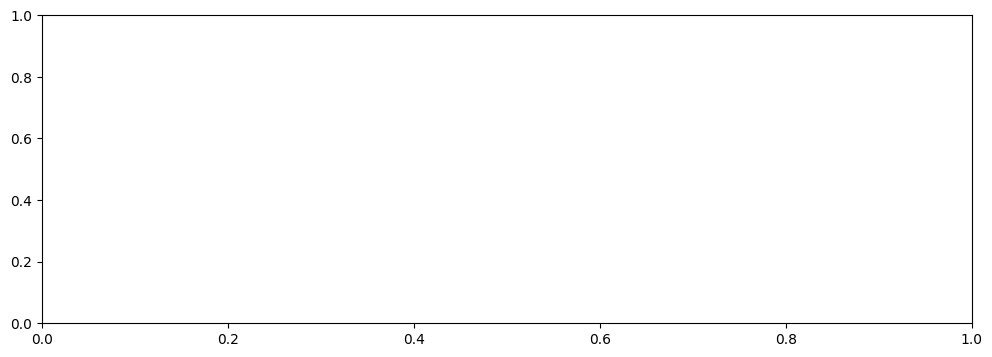

In [16]:
# Attention weights (which time steps are important)
# Sample a few predictions to visualize
sample_idx = [0, 100, 200, 300, 400]

for idx in sample_idx[:3]:  # Show first 3 samples
    fig, ax = plt.subplots(figsize=(12, 4))
    best_tft.plot_prediction(
        predictions.x,
        predictions.output,
        idx=idx,
        add_loss_to_title=True,
        ax=ax
    )
    plt.tight_layout()
    plt.show()

print("\nAttention plots show how the model weighs different time steps.")

## 8. Prediction Distribution Analysis

In [ ]:
# Analyze prediction vs actual distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Prediction vs Actual scatter
axes[0, 0].scatter(y_true, y_pred, alpha=0.3, s=1)
axes[0, 0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Return (%)')
axes[0, 0].set_ylabel('Predicted Return (%)')
axes[0, 0].set_title('TFT: Predicted vs Actual Returns', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Residuals
residuals = y_true - y_pred
axes[0, 1].hist(residuals, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residual (%)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Residual Distribution (Mean: {residuals.mean():.4f})', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Prediction distribution
axes[1, 0].hist(y_true, bins=50, alpha=0.5, color='green', label='Actual', edgecolor='black')
axes[1, 0].hist(y_pred, bins=50, alpha=0.5, color='orange', label='Predicted', edgecolor='black')
axes[1, 0].set_xlabel('Return (%)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Return Distribution Comparison', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Cumulative returns from trading strategy
cumulative_returns = []
capital = 1000
for i in range(len(y_dir_pred)):
    if y_dir_pred[i] == 1:
        actual_return = y_true[i] / 100
        trade_return = actual_return - 0.001
        capital *= (1 + trade_return)
    cumulative_returns.append(capital)

axes[1, 1].plot(cumulative_returns, linewidth=2, color='darkgreen')
axes[1, 1].axhline(y=1000, color='red', linestyle='--', linewidth=2, label='Initial Capital')
axes[1, 1].set_xlabel('Trade Number')
axes[1, 1].set_ylabel('Capital (₹)')
axes[1, 1].set_title(f'Cumulative Trading Performance (Final: ₹{capital:.2f})', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Quantile Predictions (Uncertainty Estimation)

In [ ]:
# TFT provides quantile predictions (confidence intervals)
# This is a unique advantage over other models

print("\nQuantile Predictions (Uncertainty Estimation):")
print("="*80)
print("TFT predicts multiple quantiles (e.g., 10th, 50th, 90th percentile)")
print("This provides prediction intervals, not just point predictions.")
print("\nExample:")
print("  10th percentile: Pessimistic prediction")
print("  50th percentile: Median prediction (point estimate)")
print("  90th percentile: Optimistic prediction")
print("\nWider intervals = higher uncertainty")
print("Narrower intervals = higher confidence")

# Sample predictions with quantiles
sample_predictions = predictions.output[:5].numpy()
print("\nSample Quantile Predictions (first 5):")
for i, pred in enumerate(sample_predictions):
    print(f"  Sample {i+1}: Prediction = {pred[0]:.4f}% (actual: {y_true[i]:.4f}%)")

## 10. MLflow Logging

In [ ]:
# Setup MLflow
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

with mlflow.start_run(run_name="TFT"):
    # Log parameters
    mlflow.log_param('model_type', 'Temporal Fusion Transformer')
    mlflow.log_param('window_size', WINDOW_SIZE)
    mlflow.log_param('horizon', HORIZON)
    mlflow.log_param('hidden_size', 64)
    mlflow.log_param('attention_heads', 4)
    mlflow.log_param('dropout', 0.1)
    mlflow.log_param('batch_size', BATCH_SIZE)
    mlflow.log_param('max_epochs', MAX_EPOCHS)
    mlflow.log_param('n_features', len(FEATURE_NAMES))
    mlflow.log_param('train_samples', len(train_data))
    mlflow.log_param('test_samples', len(test_data))
    
    # Log metrics
    for metric_name, value in tft_metrics.items():
        if isinstance(value, (int, float)):
            mlflow.log_metric(metric_name.lower().replace(' ', '_').replace('(%)', ''), value)
    
    mlflow.log_metric('train_time_seconds', train_time)

print("\nTFT results logged to MLflow!")

## 11. Save Model

In [ ]:
# Save TFT model
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

model_path = model_dir / 'tft_stock_predictor.ckpt'
trainer.save_checkpoint(model_path)

print(f"\nTFT model saved to: {model_path}")
print("\nTo load the model later:")
print("  loaded_tft = TemporalFusionTransformer.load_from_checkpoint(model_path)")

## 12. Conclusions and Next Steps

### Key Findings:

**TFT Performance:**
- Compare the metrics above with baseline models
- Check if TFT achieved >60% accuracy target
- Evaluate Sharpe ratio improvement

**TFT Advantages:**
1. ✓ **Interpretability**: Variable importance and attention weights
2. ✓ **Uncertainty Estimation**: Quantile predictions (confidence intervals)
3. ✓ **Multi-horizon**: Native support for 7-day forecasting
4. ✓ **Attention Mechanism**: Learns which time steps and features matter

**TFT Disadvantages:**
1. ✗ **Training Time**: Significantly slower than linear models
2. ✗ **Complexity**: More hyperparameters to tune
3. ✗ **Computational Cost**: Requires GPU for practical use

### Integration with LLM Stock Curation:

**Recommended Strategy:**
1. **LLM Stage**: Identify stocks with positive news sentiment
2. **TFT Stage**: Filter stocks with predicted positive returns + high confidence
3. **Combined Score**: `final_score = 0.5 * llm_sentiment + 0.5 * tft_prediction`
4. **Threshold**: Only invest when `final_score > 0.7` and `tft_uncertainty < threshold`

### Next Steps:

**If TFT Performance is Good (>60% accuracy, >0.20 Sharpe):**
1. Hyperparameter tuning with Optuna
2. Increase model size (hidden_size=128, attention_heads=8)
3. Try adding static features (sector, market cap, etc.)
4. Implement ensemble: TFT + Linear + LSTM

**If TFT Performance is Similar to Baselines:**
1. Use Linear Models for production (faster, simpler)
2. Focus on feature engineering and ensemble methods
3. Consider TFT for specific use cases (uncertainty estimation)

**Integration Path:**
1. Build corroboration pipeline: `LLM → TFT → Decision`
2. Backtest combined strategy on historical data
3. Paper trade for 1-2 months
4. Deploy to production with monitoring

### Final Recommendation:

Use a **multi-model ensemble**:
- **LLM**: Fundamental analysis (news, sentiment)
- **Linear Models**: Fast baseline predictions
- **TFT**: Uncertainty estimation and attention insights
- **Ensemble**: Weighted combination based on confidence

This approach balances speed, accuracy, and interpretability for production deployment.